<a href="https://colab.research.google.com/github/E1250/cnn_cv_gans-ref/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Youtube Video - https://www.youtube.com/watch?v=56rCSTUaYsA&list=PLyhJeMedQd9TOCgmveCL0debeOQxkP6Vm&index=3

# Deep Convolutional GAN

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

In [3]:
# Load MNIST Dataset
(x_train , _),(_,_) = keras.datasets.mnist.load_data()
# train_dataset, validation_dataset, test_datatset = keras.datasets.celeba.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Noramlizing the data
x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
x_train = (x_train - 127.5) / 127.5

In [5]:
# Creating datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size = 1024).batch(BATCH_SIZE) # buffer_size -> temp memory

In [6]:
# Create the model
# Generator - Converting noise to image (up-sampling)
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Discriminator - (down-sampling)
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
# Define the loss function for the generator and discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [9]:
# Optimizers
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [10]:
# Define the training loops
def train_step(images):
  # Generating noise from a normal distribution
  fake_img_noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(fake_img_noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    print("gen_loss", np.mean(gen_loss), "disc_loss", np.mean(disc_loss))

In [11]:
# Train the GAN
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in dataset:
      train_step(batch)

In [ ]:
train(dataset, EPOCHS)

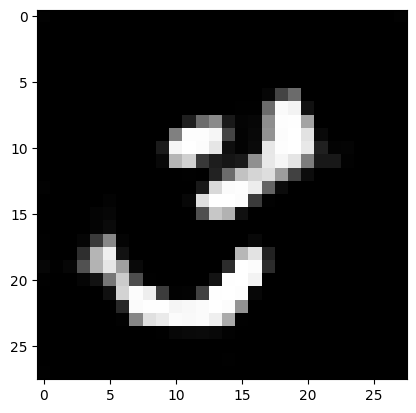

In [39]:
import matplotlib.pyplot as plt
tf.experimental.numpy.experimental_enable_numpy_behavior()
plt.imshow(generator(np.random.randn(1,100)).reshape(28,28),cmap = 'gray');